
# Multilabel classification and zero-shot learning
## Jochem Gietema and Pieter-Jan Reynaert
## 05.10.19
## Introduction
Multilabel classification is an application in computer vision that is both fundamental and challenging. Although many specialised applications in computer vision already exist (single-label classification, image segmentation,...), these applications all have specialized models and some need data that is scarce (such as pixel annotations in image segmentation). Therefore it would be greatly beneficial if a model can be developed that can perform a range of computer vision tasks and does not require carefully curated data. Therefore we work on a visual-semantic embedding network that could do the following tasks in a generalist fashion without requiring carefully curated and annotated data:

    1. Multilabel classification
    2. Image segmentation
    3. Zero-shot learning 

### Visual-semantic embedding network
In essence the visual-semantic embedding network is made of two main components: a CNN and an embedding network. The CNN is similar to a single-label classification CNN except that it ends at the final convolutional layer. Instead of using it to perform classification through one-hot encoding, it is used to create an embedding using a vector representation of labels. The vector representations of the labels are created by projecting the labels onto a 300 dimensional space according to their similarity. This similarity metric is obtained by analyzing a large corpus of text (word2vector models). This setup enables us to do multi-label classification, since scores for several labels can be calculated at different locations in the convolutional layer which can be present at the same time. Moreover since the convolutional layers maintains spatial information, we can perform image segmentation (we know where the labels are found in the convolutional layer) and thus learn different labels at different locations. Finally, the vector representation removes the dependency of the model on the number of classes it was trained on and allows us to perform one-shot learning. A new class would just become a new vector we observe in a space the model already learned and can classify since it learned from a large corpus of text. For these reasons this sort of model could therefore be very useful.
 



## Methodology & Goals

Our approach in this notebook is to build further on the previous cohort's model, named Swiss Knife. Their goal was to build a model that could perform well on a wide range of tasks (as specified above) and to experiment with and explore  
- __get the model to perform well on the teuko-lunchbox dataset__
- __build a model that is competitive to the [clarif.ai](https://clarifai.com/models/food-image-recognition-model-bd367be194cf45149e75f01d59f77ba7) image recognition model__

To achieve this we work on 4 main steps:

### 1) Improve & test the Swiss Knife model
There are quite a few comments like _`Needs to be tested and documented!!!!`_ in the current Swiss Knife Model.  
This makes it unclear if the current model is doing what it should do. We will need to refactor and test the model quite a bit to see if everything is working well.  
This week, we added a few things that should improve the reliability of the model:
- The fastai version of the model is updated from 1.0.43 to 1.0.52 
- We initialized the weights of the convolutional layers with `kaiming_normal_` instead of `nn.init.normal`
- We added mixed precision training to speed up training 

Next week, we will run more extensive tests with the debugger, add a few test notebooks and add more documentation to the code.

### 2) Add more multilabel food images to the dataset 
We crawled more multilabel food images via Google images. We also worked on making the multilabel images more representative and creating labels wehere enough data can be sampled. We still need to add that data to the dataset we use at the moment, but we're confident that this will improve the performance of the model.

### 3) Add/Improve labels to the embedding dictionary  
To make the model perform better on zero-shot learning, we will add more labels to the embedding dictionary. We are also experimenting with creating a better methodology to define vectors for multi-word labels (currently the individual vectors are averaged out). 

### 4) Tune hyperparameters, experiment with transforms  
It looks like there is still quite a lot of room to optimize the model. We experimented with adding weight decay and the transforms used in the [SoTA food-101 notebook](https://github.com/fellowship/platform-demos2/blob/master/food-101/food101-rn50-512-90.ipynb). In addition, we can try to train a model with a smaller images and use that model as a transfer learning model to train on images with a bigger size (see [fastai v3 part 1 lesson 3](https://youtu.be/MpZxV6DVsmM?t=3086)). 

## Data, Analysis and Results


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from ImageEmbedModel import * 
from fastai_multilabel import ClassificationInterpretation_Multi

In [3]:
path = Path('/opt/data')

In [4]:
labels = pd.read_csv(path/'all_food_processed_2.csv')
embed_dict = pickle.load(open(path/'food_dict.pkl', 'rb'))

### Metrics

In [5]:
def recall_1(preds, y_true): return recall_topk(preds, y_true, k=1)
def recall_5(preds, y_true): return recall_topk(preds, y_true, k=5)
def recall_10(preds, y_true): return recall_topk(preds, y_true, k=10)

### Explore Data

Our entire dataset contains more than 1,400,000 images of food and is a merge of a few datasets:  
- the food-101 dataset
- a twin dataset of food-101 named [UPMC Food-101 ](http://visiir.lip6.fr/explore)
- a scraped dataset of 500k German food recipes
- a dataset with food images crawled from Google Images
- [UEC FOOD 256](http://foodcam.mobi/dataset256.html), a dataset with mostly images of popular foods in Japan

In [8]:
def plot_random_images(rows, cols, width, height):
    for i, ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten()):
        img = labels.sample(1)        
        open_image(str(path) + "/" + img.iloc[0][0]).show(ax, ax)
        ax.title.set_text(img.iloc[0][1])

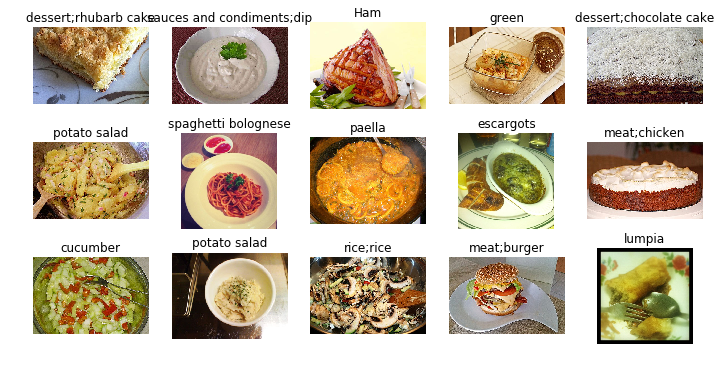

In [10]:
plot_random_images(3, 5, 12, 6)

Some images have multiple labels (e.g. Dessert;chocolate cake or meat;burger), others have just one ('lumpia').  
As noted in ['New Food-101 SoTA with fastai and platform.ai’s fast augmentation search'](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/), the food-101 dataset, which is part of our dataset, is pretty dirty and contains mislabeled images or images that are just hard to classify in general.  The image labeled 'meat;chicken' is a cake and not meat.

In [15]:
num_images_with_multiple_labels = len(labels[labels['label'].str.contains(';')])
print(f'multilabel images: {num_images_with_multiple_labels}\t single label images: {len(labels) - num_images_with_multiple_labels}')
print('ratio: {:.2}'.format(num_images_with_multiple_labels/len(labels)))

multilabel images: 352988	 single label images: 1056437
ratio: 0.25


#### The need for extra multilabel images
Specifically, just 25% of our dataset contains images with multiple labels. This is the reason why we worked on adding more multilabel images to our dataset.

At the moment, quite a few of these multilabel images come from a dataset that was made by crawling google images with random combinations of classes of the teuko food dataset. Because most of these combinations are pretty unusual, the previous cohort only downloaded three images per combination to avoid downloading images that are not representative of the multilabel class. 

To solve this issue, we first expand our number of single classes by adding a list of most popular foods from Ranker and adding it to the teuko food single classes. Next we construct multilabel classes from our list of single classes.
To evaluate how realistic/good a multilabel class is, we compare its occurence on a dataset of 500k restaurant dishes and use the total number of occurences and relative number of occurences compared to the single classes as selection metrics. We just downloaded the extra data on Friday and will start to train with it next week.

Let's have a look at our embedding dictionary.

In [20]:
list(embed_dict.keys())[:22], f'\nnumber of keys: {len(embed_dict.keys())}')

(['apple',
  'applesauce',
  'asparagus',
  'avocado',
  'baby',
  'Babybel',
  'bacon',
  'baguette',
  'banana',
  'barbecued',
  'red',
  'pork',
  'in',
  'sauce',
  'with',
  'rice',
  'basmati',
  'Batavia',
  'beef',
  'bell',
  'black',
  'blueberries'],
 'number of keys: 580')

Our embedding dictionary currently contains only 580 classes. Most of these classes are food, but it is clear that we can still improve this dictionary quite a lot.  
It is not very likely that the embedding for 'baby' will help us to classify an image of 'baby back ribs'.

A potential solution for this is to create our own vector space from a text corpus and introduce bigram vectors for the multi-word classes. A downside of this is that it means we have to retrain the entire word2vector model, which takes quite some time. Currently exploring better ways to do this.

In [ ]:
set(labels[labels['label'].str.contains('baby')]['label'])

### Create learner

We experimented a bit with adding the transforms that were added to reach a new state of the art on the food-101 dataset. It did not improve our results a lot, but it helped a little bit.

In [6]:
optimal_tfms = [RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40.0, 40.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.4)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': 0.2}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.4166666666666667, 2.4)}, p=0.75, resolved={}, do_run=True, is_random=True)]

In [7]:
ds_tfms = ([rand_crop()] + optimal_tfms, [crop_pad()])

To experiment quickly, we train on just 2 percent of the data.

In [8]:
data = (ImageItemList_for_Embed.from_df(labels, path, folder='')
        .use_partial_data(0.02)
        .split_from_df('valid')
        .label_from_df(cols='label', label_delim=';', embed_keys=embed_dict.keys(), num_labels=100,
                       consider_val_as_train=True)
        .transform(ds_tfms, size=224).databunch(bs=32))

In [9]:
len(data.train_ds), len(data.valid_ds), len(data.classes)

(27911, 277, 741)

In [10]:
learn = Learner(data, spatial_model(embed_dict, cap=10), wd=.1, loss_func=BCEWithLogitsFlat(), 
                metrics = [recall_1, recall_5, recall_10],).to_fp16(flat_master=True)

### Train

In [11]:
learn.split(lambda m: (learn.model.body[6], learn.model.body[-1][-1]))
learn.freeze()
learn.model.freeze_embeddings()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04


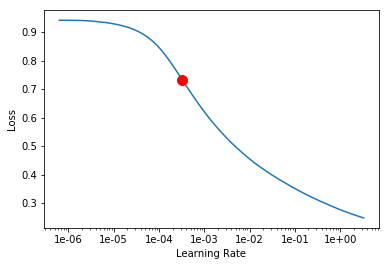

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
# lr = 2.29E-04
lr = 3.31E-04

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,recall_1,recall_5,recall_10,time
0,0.061278,0.057715,0.144705,0.360650,0.483514,03:00
1,0.051424,0.045882,0.297353,0.626956,0.752708,03:01
2,0.046581,0.042709,0.376173,0.689230,0.778279,03:00
3,0.043491,0.040293,0.405054,0.703971,0.798135,03:00
4,0.040775,0.039917,0.392419,0.716606,0.799940,03:00


Because we are using a custom model, the normal `ClassificationInterpretation` does not work. The previous cohort wrote an implementation of that class, but we couldn't get it to work yet. We will try to fix it this week to make it easier to analyse the training results.

## Next steps

- Continue to work on our approach outlined at the top of this notebook
- Train our improved model on the food-teuko dataset and see how competitive it is to clarifai